# Outlier Analysis: Unveiling Anomalies in the Data

In a dataset as fraught with complexities as police brutality incidents, it's inevitable that some data points will stand out as unusual.  This notebook embarks on a mission to identify and investigate these outliers.  We'll employ the Interquartile Range (IQR) to pinpoint potential anomalies and explore their significance using clustering techniques.  

**Key Steps:**

* **Outlier Detection:**  Employing IQR to flag suspicious data points.
* **Clustering:** Applying K-means clustering to uncover patterns within the data, potentially revealing insights about outlier groups. 

**Note:** Remember, outliers aren't always errors. They can sometimes highlight extraordinary cases that warrant deeper investigation. 

### 4. Reviving Our Data: Initialization Rituals

Time to resurrect our meticulously cleaned dataset and summon the essential libraries.  Consider this notebook our data necromancy grimoire!  

_**Note:** If you didn't meticulously clean your data in the last notebook, well...  expect some unexpected surprises._

In [1]:
import ipynb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
df = pd.read_parquet('police_brutality.parquet')
df.head()

,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,...,age_group,threat_level,namesake_count,year,month,day_of_week,day,season,bank_holiday,lunar_phase
id,,,,,,,,,,,,,,,,,,,,,
3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,...,adult,Serious Threat,1,2015,January,Friday,2,Winter,False,New Moon
4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,...,adult,Serious Threat,1,2015,January,Friday,2,Winter,False,New Moon
5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,...,young adult,Moderate Threat,1,2015,January,Saturday,3,Winter,False,New Moon
8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,...,adult,Moderate Threat,1,2015,January,Sunday,4,Winter,False,New Moon
9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,...,adult,Moderate Threat,1,2015,January,Sunday,4,Winter,False,New Moon


### Data Sanity Check: Success!

It seems our meticulous cleaning efforts have paid off. The imported data appears to be in excellent shape – no null values in sight! Let's give ourselves a pat on the back before diving into outlier analysis. 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9495 entries, 3 to 10272
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        9495 non-null   datetime64[ns]
 1   threat_type                 9495 non-null   category      
 2   flee_status                 9495 non-null   category      
 3   armed_with                  9495 non-null   category      
 4   city                        9495 non-null   category      
 5   county                      9495 non-null   category      
 6   state                       9495 non-null   category      
 7   latitude                    9495 non-null   float64       
 8   longitude                   9495 non-null   float64       
 9   location_precision          9495 non-null   category      
 10  name                        9495 non-null   string        
 11  age                         9495 non-null   float64       
 

In [4]:
df.nunique()

date                          3150
threat_type                      8
flee_status                      5
armed_with                      23
city                          3537
county                         912
state                           51
latitude                      8384
longitude                     8383
location_precision               7
name                          9111
age                             83
gender                           4
race                            12
race_source                      5
was_mental_illness_related       2
body_camera                      2
substituted_location             2
substituted_age                  2
location_fatality_counter       46
age_group                        8
threat_level                     5
namesake_count                   4
year                            10
month                           12
day_of_week                      7
day                             31
season                           4
bank_holiday        

### Initial Data Scrutiny: Anomalies Emerge

A closer look reveals :

* **Suspect Longitude Spread:** The longitude's standard deviation seems suspiciously high.  We'll keep a close eye on this during our analysis.
* **A Difficult Reality:** The age range, with a minimum of 2 and a maximum of 92, underscores the tragic reality of this dataset. This isn't just about statistics – it's about lives lost at both ends of the age spectrum. 

_**Note:** These anomalies might be genuine outliers or artifacts of our data preparation.  Let's dig deeper!_

In [5]:
df.describe()

,date,latitude,longitude,age,location_fatality_counter,namesake_count,year,day
count,9495,9495.000000,9.495000e+03,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000
mean,2019-09-29 11:15:20.189573376,32.589764,-9.486230e+11,37.323223,5.528805,13.509110,2019.258768,15.511006
min,2015-01-02 00:00:00,0.000000,-9.007175e+15,2.000000,0.000000,1.000000,2015.000000,1.000000
25%,2017-06-05 00:00:00,31.757751,-1.107048e+02,28.000000,0.000000,1.000000,2017.000000,8.000000
50%,2019-11-02 00:00:00,35.209191,-9.020568e+01,35.000000,0.000000,1.000000,2019.000000,15.000000
75%,2022-02-16 00:00:00,39.748528,-8.081916e+01,45.000000,0.000000,1.000000,2022.000000,23.000000
max,2024-03-26 00:00:00,71.301255,0.000000e+00,92.000000,195.000000,345.000000,2024.000000,31.000000
std,NaN,12.546798,9.243600e+13,12.680826,25.485647,64.371601,2.687878,8.829773


### Investigating Outlier Hotspots

The outlier summary reveals a pattern: location features (**longitude** and **latitude**) and the **age** column seem to be the primary sources of potential anomalies.  Time to zoom in for a closer look! 


In [6]:
outliers_summary = {'mild': {}, 'extreme': {}}

for column in df.select_dtypes(include='number'):
	Q1 = df[column].quantile(0.25)
	Q3 = df[column].quantile(0.75)
	IQR = Q3 - Q1

	mild_outliers = ((df[column] < Q1 - 1.5 * IQR) |
	                 (df[column] > Q3 + 1.5 * IQR)).sum()
	extreme_outliers = ((df[column] < Q1 - 3 * IQR) |
	                    (df[column] > Q3 + 3 * IQR)).sum()

	outliers_summary['mild'][column] = mild_outliers
	outliers_summary['extreme'][column] = extreme_outliers

print("Summary of outliers:")
for category, category_outliers in outliers_summary.items():
	print('-----------------------------------\n'
	      f'{category.capitalize()} outliers:'
	      '\n-----------------------------------')
	for column, num_outliers in category_outliers.items():
		print(f'|{column}|: {num_outliers} outliers')

Summary of outliers:
-----------------------------------
Mild outliers:
-----------------------------------
|latitude|: 1106 outliers
|longitude|: 1083 outliers
|age|: 126 outliers
|location_fatality_counter|: 2031 outliers
|namesake_count|: 424 outliers
|year|: 0 outliers
|day|: 0 outliers
-----------------------------------
Extreme outliers:
-----------------------------------
|latitude|: 1065 outliers
|longitude|: 1 outliers
|age|: 0 outliers
|location_fatality_counter|: 2031 outliers
|namesake_count|: 424 outliers
|year|: 0 outliers
|day|: 0 outliers


### Assessing Imputation Impact: Visualizing Outliers

Let's dissect our outlier situation further. To gauge whether our imputation methods might be influencing the results, we'll visualize the data both with **and** without the imputed values. This should help clarify if those filled-in values are skewing our outlier detection.

**Plan of Action:**

1. **Filter the Data:** Create subsets of our dataframe – one with imputed data, one without.
2. **Generate Visualizations:** Create boxplots or similar visualizations for 'age' and location features, comparing the outlier distribution in both subsets.

Ready to see if our imputations are the culprits? 🧐 


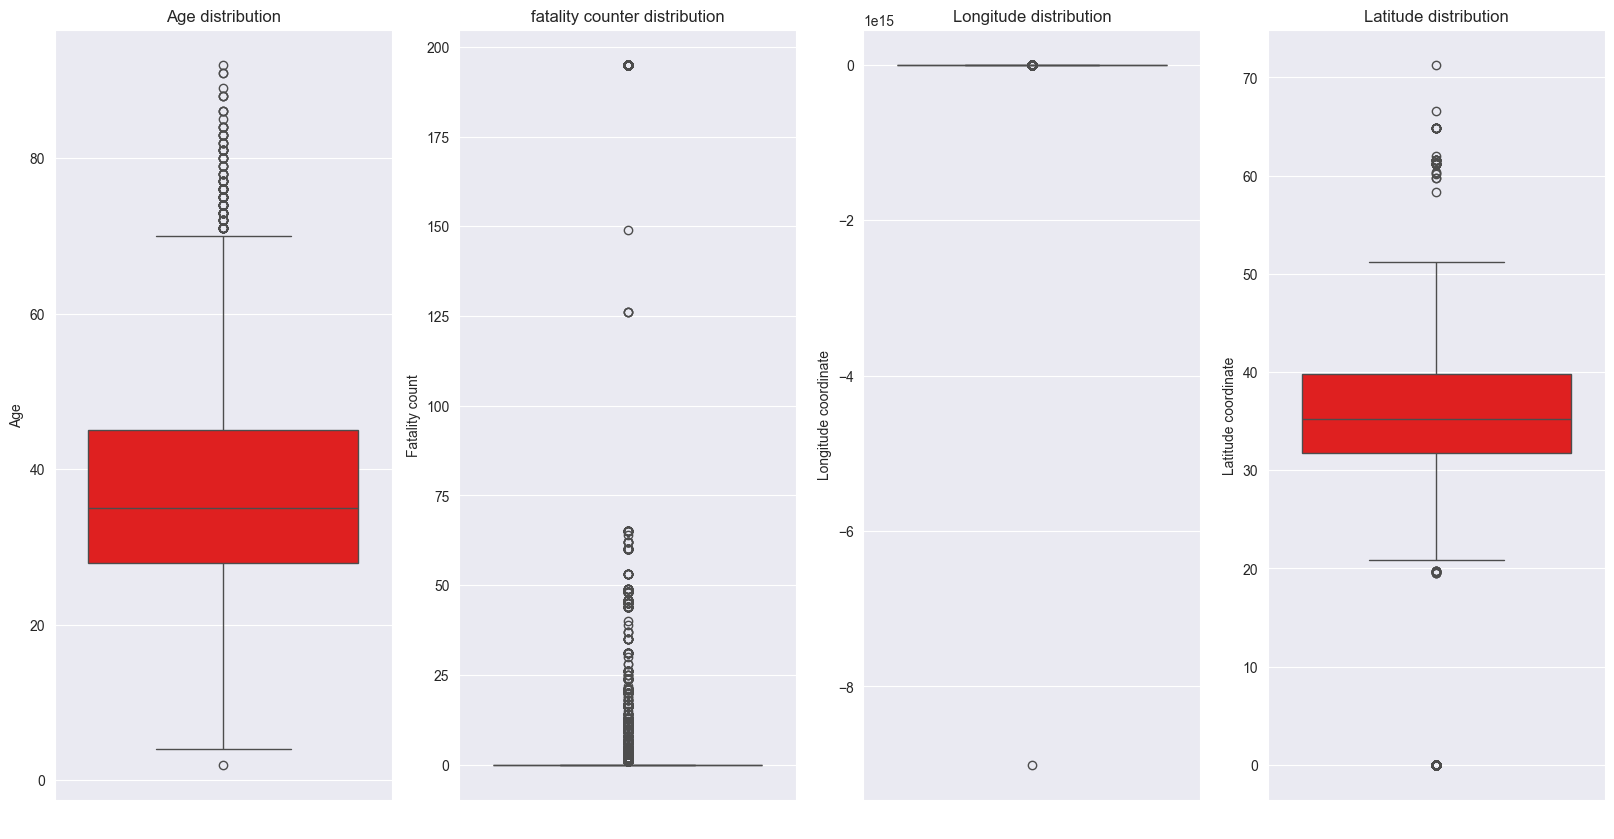

In [7]:
def plot_boxplot(data, column, title,
                 xlabel, ylabel, ax):
	"""
    Creates a boxplot for a specified column in a DataFrame and displays it on a given axis.

    Args:
        data (pandas.DataFrame): The DataFrame containing the data for the boxplot.
        column (str): The name of the column within the DataFrame to use for the boxplot.
        title (str): The title to display above the boxplot.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis.
        ax (matplotlib.axes.Axes): The axis object on which to plot the boxplot.
    """

	sns.boxplot(y=column, data=data, ax=ax, color='red')
	ax.set_title(title)
	ax.set_xlabel(xlabel)
	ax.set_ylabel(ylabel)
	ax.tick_params(axis='y')


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
plot_boxplot(df, 'age',
             'Age distribution', ' ',
             'Age', axes[0])

plot_boxplot(df, 'location_fatality_counter',
             'fatality counter distribution',
             ' ', 'Fatality count', axes[1])

plot_boxplot(df, 'longitude', 'Longitude distribution',
             ' ', 'Longitude coordinate', axes[2])

plot_boxplot(df, 'latitude', 'Latitude distribution',
             ' ', 'Latitude coordinate', axes[3])

### Refining Our Outlier Analysis

Let's address two potential sources of bias:

1. **Imputation Impact:** We'll visualize the data without imputed values to isolate their effect on outlier detection.

2. **Zero-Fatality Locations:**  While not inherently negative, locations with zero recorded fatalities can skew visualizations.  We'll filter these out for a more focused analysis. 

**Plan of Action:**

1. **Filter the Data:** 
   * Create a subset without imputed values.
   * Create a subset excluding locations with zero fatalities.

2. **Generate Visualizations:**  Replicate our earlier visualizations (boxplots, etc.) using the filtered datasets for 'age', 'longitude', and 'latitude'. 

Let's see how our outlier landscape changes! 


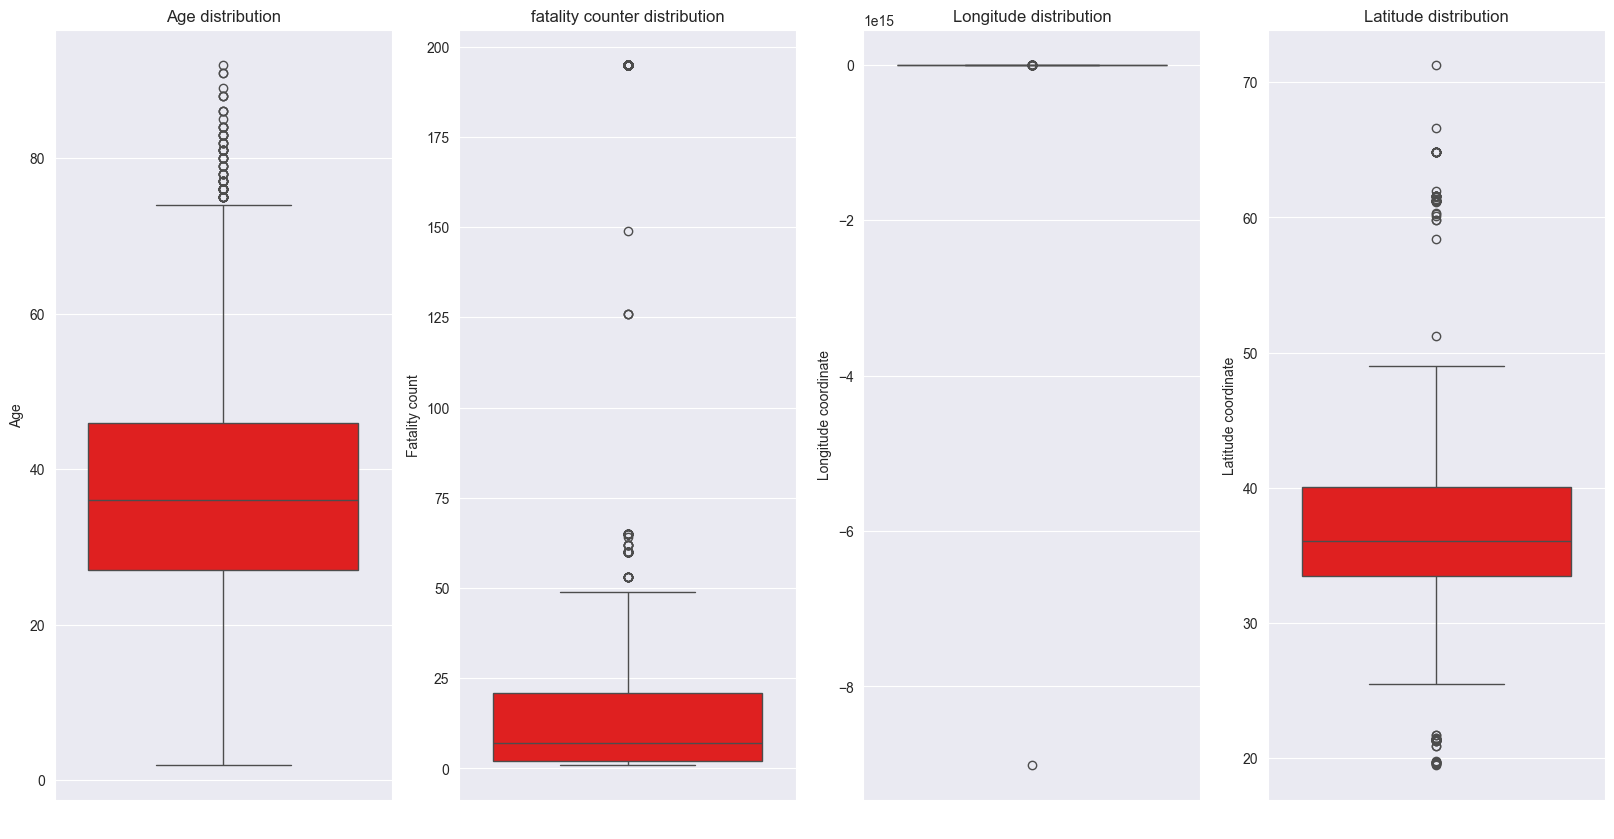

In [8]:
unsubsituted_age = df[(df['substituted_age'] == False)]
non_zero_fatality_count = df[(df['location_fatality_counter'] != 0)]
unsubsituted_location = df[(df['substituted_location'] == False)]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
plot_boxplot(unsubsituted_age, 'age',
             'Age distribution', ' ',
             'Age', axes[0])

plot_boxplot(non_zero_fatality_count, 'location_fatality_counter',
             'fatality counter distribution',
             ' ', 'Fatality count', axes[1])

plot_boxplot(unsubsituted_location, 'longitude', 'Longitude distribution',
             ' ', 'Longitude coordinate', axes[2])

plot_boxplot(unsubsituted_location, 'latitude', 'Latitude distribution',
             ' ', 'Latitude coordinate', axes[3])

### Mars Invader Alert: Cleaning Up Geographical Errors

Hold on, did someone get lost on the way to Mars? Our outlier analysis has flagged a longitude value squarely in the middle of the Red Planet. This is clearly an error, so let's remove that row for a more Earth-bound analysis. 


In [9]:
unsubsituted_location['longitude'].sort_values(ascending=True).head()

id
9473    -9.007175e+15
7116    -1.600069e+02
7990    -1.595407e+02
10085   -1.582155e+02
3962    -1.581365e+02
Name: longitude, dtype: float64

In [10]:
df = df.drop(index=9473)

### Outlier Investigation: Mission Accomplished (For Now)

We've battled those pesky outliers and cleaned up the most glaring anomalies.  While there might always be more to uncover, it's time to shift our focus to the clustering analysis. 


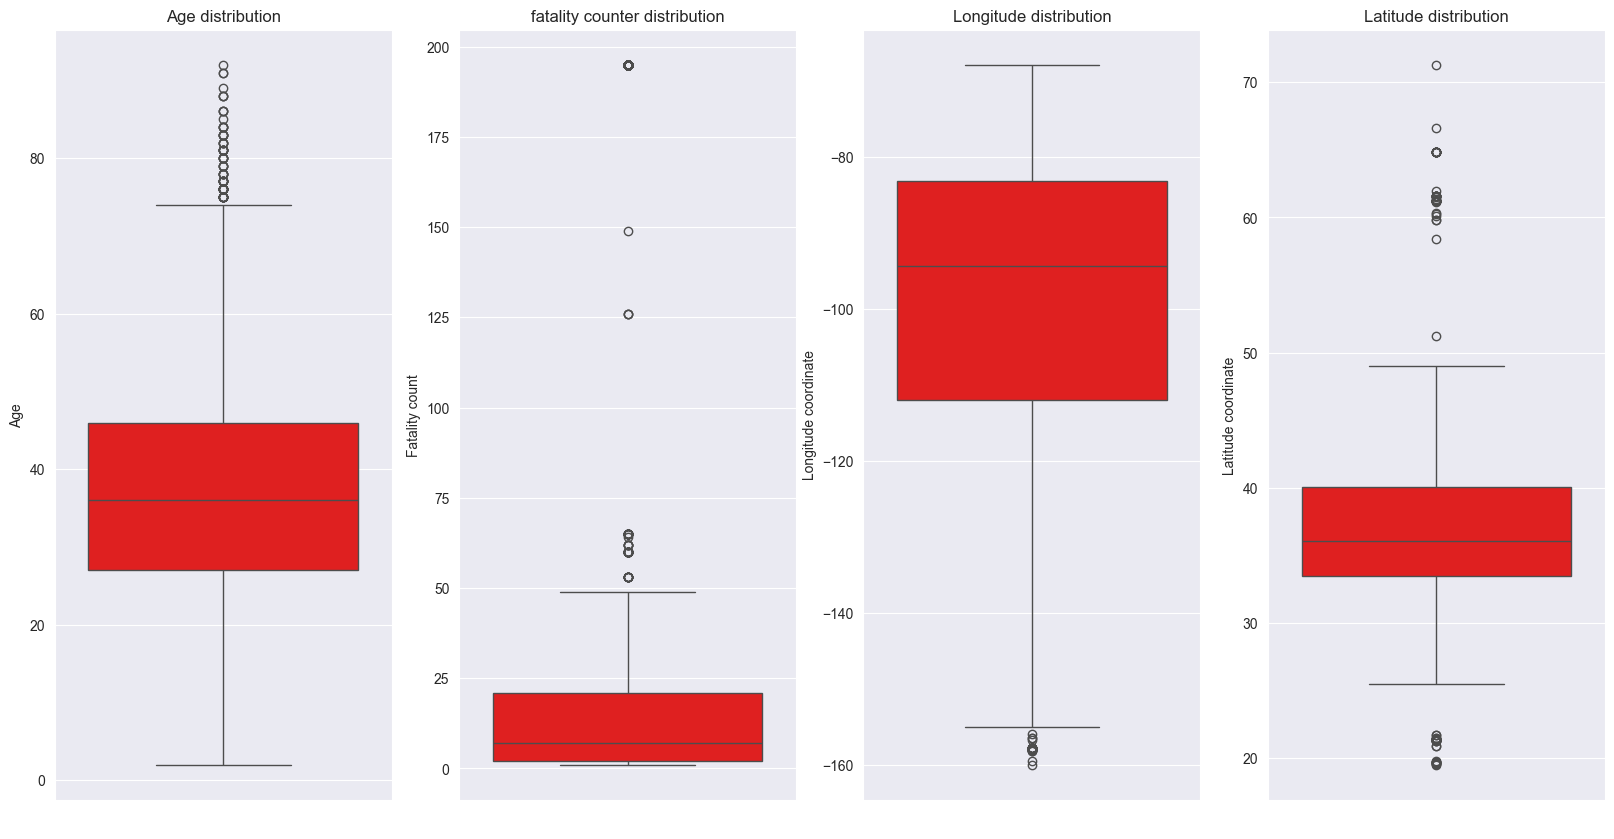

In [11]:
unsubsituted_location = df[(df['substituted_location'] == False)]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
plot_boxplot(unsubsituted_age, 'age',
             'Age distribution', ' ',
             'Age', axes[0])

plot_boxplot(non_zero_fatality_count, 'location_fatality_counter',
             'fatality counter distribution',
             ' ', 'Fatality count', axes[1])

plot_boxplot(unsubsituted_location, 'longitude', 'Longitude distribution',
             ' ', 'Longitude coordinate', axes[2])

plot_boxplot(unsubsituted_location, 'latitude', 'Latitude distribution',
             ' ', 'Latitude coordinate', axes[3])

### Outlier Strategy: Marking and Moving On

For now, we've addressed the most glaring outliers. However, to enable more sophisticated analysis in the future, let's revisit feature engineering and add a boolean column flagging these potential outliers. This will give us the flexibility to isolate or include them as needed. 


In [12]:
def calculate_outlier_thresholds(data):
	"""
    Calculates the upper and lower outlier thresholds based on the Interquartile Range (IQR).
    Args:
        data (pandas.Series or array-like): A numerical data series.
    Returns:
        tuple: A tuple containing the lower bound and upper bound thresholds.
    """

	Q1 = data.quantile(0.25)
	Q3 = data.quantile(0.75)
	IQR = Q3 - Q1
	upper_bound = Q3 + 1.5 * IQR
	lower_bound = Q1 - 1.5 * IQR

	return lower_bound, upper_bound


def detect_outliers(df, numerical_features):
	"""
    Detects outliers in a DataFrame and creates a new 'outliers' column with boolean values.
    Utilizes the IQR method for outlier detection.
    Args:
        df (pandas.DataFrame): The DataFrame to analyze.
        numerical_features (list): A list of column names containing numerical data.
    Returns:
        pandas.DataFrame: The DataFrame with the added 'outliers' column.
    """

	df['outliers'] = False

	for feature in numerical_features:
		lower_bound, upper_bound = calculate_outlier_thresholds(df[feature])
		outlier_condition = (df[feature] < lower_bound) | (df[feature] > upper_bound)
		df.loc[outlier_condition, 'outliers'] = True

	return df


numerical_features = ['age', 'latitude', 'longitude', 'location_fatality_counter']

df = detect_outliers(df, numerical_features)

### 5. Data Checkpoint: A Quick Backup Before Clustering 

_Before embarking on the clustering analysis, let's take a strategic pause. We'll save our carefully transformed data in a Parquet file, ensuring we have a clean starting point for our final notebook._

In [13]:
df.to_parquet('police_brutality_outliers.parquet')

### 6. K-Means Prep: Data Wrangling 

_Before diving into clustering, we need to get our data algorithm-ready.  This means encoding categorical features into numerical formats and scaling features to ensure a balanced analysis._

### Preparing Data for K-Means: Numerical Transformation

Before diving into K-means clustering, we need to make our data algorithm-friendly.  This means encoding categorical, boolean, and string features into numerical representations and applying scaling for optimal results.  

**First up:** the elbow method to determine the ideal number of clusters! 


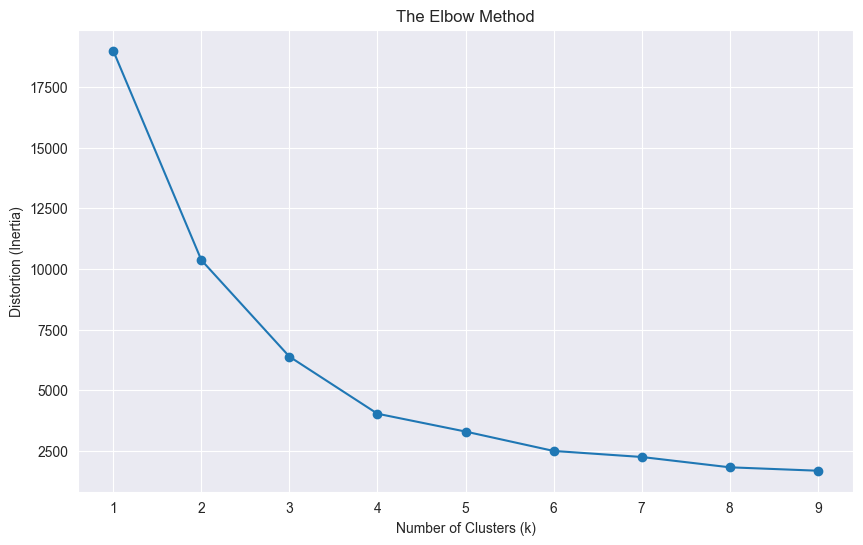

In [14]:
kmeans_df = df.copy()
encoder = LabelEncoder()

cat_cols = ['threat_type', 'flee_status', 'armed_with', 'city',
            'county', 'state', 'location_precision', 'name', 'gender',
            'race', 'race_source', 'month', 'day_of_week', 'season',
            'bank_holiday', 'lunar_phase']

for col in cat_cols:
	df[col] = encoder.fit_transform(df[col])

bool_cols = ['was_mental_illness_related', 'body_camera',
             'substituted_location', 'substituted_age']
kmeans_df[bool_cols] = kmeans_df[bool_cols].astype(int)

kmeans_df['threat_level'] = (
	encoder.fit_transform(np.ravel(kmeans_df['threat_level'])))

scaler = StandardScaler()
features = scaler.fit_transform(kmeans_df[['age', 'threat_level']])

distortions = []

for k in range(1, 10):
	kmeans = KMeans(n_clusters=k, random_state=42)
	kmeans.fit(features)

	distortions.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))

plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('The Elbow Method')
plt.show()

### Elbow Method Results: 3 Clusters Emerge

Upon careful examination of the elbow plot, it appears that **3 clusters** would provide an optimal balance between minimizing distortion and avoiding overfitting.  Let's proceed with K-means clustering using this cluster count.


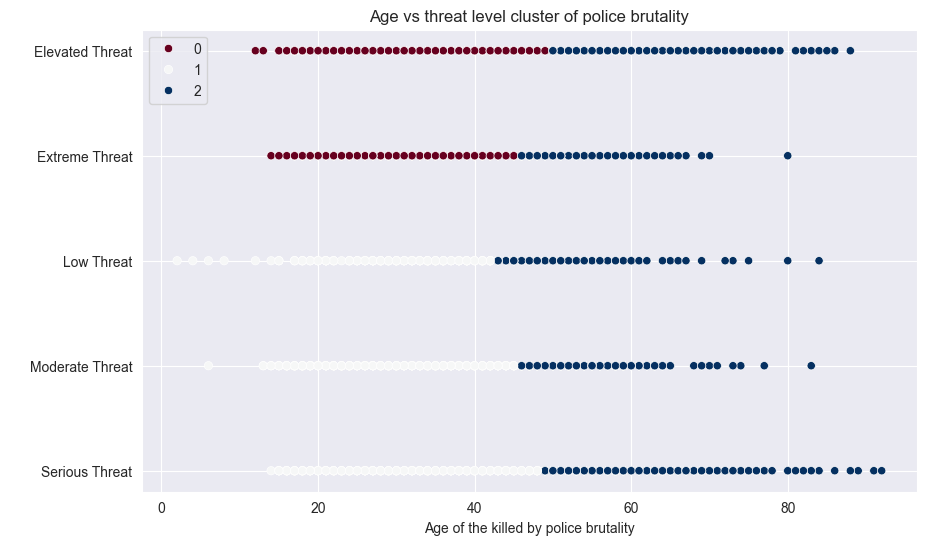

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(features)
labels = kmeans.labels_
kmeans_df['cluster'] = labels
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=df['age'],
                               y=df['threat_level'],
                               hue=kmeans_df['cluster'],
                               palette='RdBu')

plt.legend(loc='upper left')
plt.xlabel('Age of the killed by police brutality')
plt.ylabel(' ')
plt.title('Age vs threat level cluster of police brutality')
plt.show()

### Analyzing the Clusters: Patterns and Insights

Our K-means clustering has revealed distinct patterns within the data:

* **Cluster 1: High Threat, Younger Individuals:**  This cluster stands out with consistently 'Elevated' and 'Extreme' threat levels, concentrated in individuals from adolescence to around age 50.
* **Cluster 2: Moderate Threat, Similar Age Range:** This group exhibits a mix of 'Low', 'Moderate', and 'Serious' threat levels, with an age distribution similar to Cluster 1.
* **Cluster 3: Diverse Threats, Older Population:**  This cluster encompasses the full spectrum of threat levels and focuses on individuals from their mid-40s upwards. This suggests a greater variability of circumstances within this older age group.

**Important Considerations:**

* **Correlation, Not Causation:**  Remember, these clusters highlight patterns, not necessarily direct causal relationships between age and threat level.
* **Further Exploration:**  These results could spark new research questions about potential contributing factors within each cluster. 
